# Keypoint Detection on Human Body Silhouette Images

Name: HE XIANTAO

Student number: 1155132173

# Introduction
Detect human body keypoints on silhouette images.

Deep learning with PyTorch.

Side view detection is demonstrated here.

Assignment: front view keypoint detection.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')
ROOT_FOLDER = './gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment2/'

import glob
print('\nContents in the data folder:')
for x in glob.glob(ROOT_FOLDER+'data/*'):
    print(x)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/

Contents in the data folder:
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment2/data/train_kpt_side.npy
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment2/data/test_kpt_side.npy
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment2/data/train_kpt_front.npy
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment2/data/test_img_front.npy
./gdrive/My Drive/Colab Notebooks/MAEG5735-2020-Assignment2/data/test_img_side.npy
./gdrive/My D

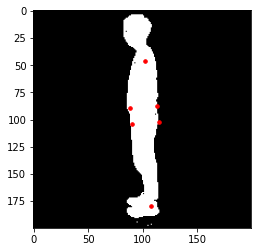

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def draw_points(image, kpts):
    plt.figure()
    plt.imshow(image, cmap='gray')
    keypoints = (kpts+0.5)*IMG_SIZE
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=50, marker='.', c='r')

# load side view data
IMG_SIZE = 200
IMG_S_TRAIN = np.load(ROOT_FOLDER+'data/train_img_side.npy')
IMG_S_TRAIN = np.unpackbits(IMG_S_TRAIN).reshape((-1,IMG_SIZE,IMG_SIZE))
IMG_S_TEST = np.load(ROOT_FOLDER+'data/test_img_side.npy')
IMG_S_TEST = np.unpackbits(IMG_S_TEST).reshape((-1,IMG_SIZE,IMG_SIZE))
KPT_S_TRAIN = np.load(ROOT_FOLDER+'data/train_kpt_side.npy')/IMG_SIZE - 0.5
KPT_S_TEST = np.load(ROOT_FOLDER+'data/test_kpt_side.npy')/IMG_SIZE - 0.5

# show one
idx = 0
draw_points(IMG_S_TRAIN[idx,:,:], KPT_S_TRAIN[idx,:,:])

# Dataset loader

In [0]:
import torch
from torch.utils.data import Dataset

class SideKeypointsDataset(Dataset):
    '''Side View Keypoints Dataset'''
    def __init__(self, img, kpt, train=True, transform=None):
        self.img = img
        self.kpt = kpt
        self.train = train
        self.transform = transform
    
    def __len__(self):
        return self.img.shape[0]
    
    def __getitem__(self, idx):
        image = self.img[idx,:,:].astype(np.float32)
        if self.train:
            keypoints = self.kpt[idx,:,:].ravel().astype(np.float32)
        else:
            keypoints = None
        sample = {'image': image, 'keypoints': keypoints}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

def prepare_train_valid_loaders(trainset, valid_size=0.2, 
                                batch_size=128):
    '''
    Split trainset data and prepare DataLoader for training and validation
    
    Args:
        trainset (Dataset): data 
        valid_size (float): validation size, defalut=0.2
        batch_size (int) : batch size, default=128
    ''' 
    
    # obtain training indices that will be used for validation
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=valid_sampler)
    
    return train_loader, valid_loader

In [0]:
from torchvision import transforms
import cv2

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        new_w = np.random.randint(w, self.output_size)
        new_h = new_w
        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))    
        if key_pts is not None:
            return {'image': img, 'keypoints': key_pts}
        else:
            return {'image': img}

class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        if h == new_h:
            return sample
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        #left = top # temp
        image = image[top: top + new_h,
                      left: left + new_w]
        if key_pts is not None:
            #key_pts = key_pts - [left/output_size, top/output_size]
            key_pts[0::2] = ((key_pts[0::2]+0.5)*w-left)/new_w-0.5
            key_pts[1::2] = ((key_pts[1::2]+0.5)*h-top)/new_h-0.5
            return {'image': image, 'keypoints': key_pts}
        else:
            return {'image': image}

class ToTensor(object):
    '''Convert ndarrays in sample to Tensors.'''
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        image = torch.from_numpy(image)
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}

batch_size = 32
valid_size = 0.2 # percentage of training set to use as validation

# Define a transform to normalize the data
tsfm_train = transforms.Compose([Rescale(205), RandomCrop(200), ToTensor()])
tsfm_test = transforms.Compose([ToTensor()])

# Load the training data and test data
trainset = SideKeypointsDataset(IMG_S_TRAIN, KPT_S_TRAIN, transform=tsfm_train)
testset = SideKeypointsDataset(IMG_S_TEST, None, train=False, transform=tsfm_test)

# prepare data loaders
train_loader, valid_loader = prepare_train_valid_loaders(trainset, 
                                                         valid_size,
                                                         batch_size)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

# Neural network structure

In [0]:
from torch import nn, optim
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p =0.5):
        '''
        Buid a forward network with arbitrary hidden layers.
        Arguments
            ---------
            input_size (integer): size of the input layer
            output_size (integer): size of the output layer
            hidden_layers (list of integers):, the sizes of each hidden layers
        '''
        super(MLP, self).__init__()
        # hidden layers
        layer_sizes = [(input_size, hidden_layers[0])] \
                      + list(zip(hidden_layers[:-1], hidden_layers[1:]))
        self.hidden_layers = nn.ModuleList([nn.Linear(h1, h2) 
                                            for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        # flatten inputs
        x = x.view(x.shape[0], -1)
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = self.output(x)    
        return x

In [0]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50, saved_model='model.pt'):
    '''
    Train the model
    
    Args:
        train_loader (DataLoader): DataLoader for train Dataset
        valid_loader (DataLoader): DataLoader for valid Dataset
        model (nn.Module): model to be trained on
        criterion (torch.nn): loss funtion
        optimizer (torch.optim): optimization algorithms
        n_epochs (int): number of epochs to train the model
        saved_model (str): file path for saving model
    
    Return:
        tuple of train_losses, valid_losses
    '''

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*batch['image'].size(0)

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # update running validation loss 
            valid_loss += loss.item()*batch['image'].size(0)

        # print training/validation statistics 
        # calculate average Root Mean Square loss over an epoch
        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses 

# Criterion and Optimizer
I change learning rate to 0.0001 and set n_epoches to 500 to train MLP

In [0]:
from torch import optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# output_size ?
# Side view keypoints: 6x2 = 12

model = MLP(input_size=IMG_SIZE*IMG_SIZE, output_size=12, 
            hidden_layers=[128, 64], drop_p=0.1)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses, valid_losses = train(train_loader, valid_loader,
                                   model, criterion, optimizer,
                                   n_epochs=500,
                                   saved_model=ROOT_FOLDER+'model.pt')                          

Epoch: 1 	Training Loss: 0.087811 	Validation Loss: 0.049523
Validation loss decreased (inf --> 0.049523).  Saving model ...
Epoch: 2 	Training Loss: 0.063000 	Validation Loss: 0.046372
Validation loss decreased (0.049523 --> 0.046372).  Saving model ...
Epoch: 3 	Training Loss: 0.057992 	Validation Loss: 0.039217
Validation loss decreased (0.046372 --> 0.039217).  Saving model ...
Epoch: 4 	Training Loss: 0.054298 	Validation Loss: 0.040090
Epoch: 5 	Training Loss: 0.050316 	Validation Loss: 0.039432
Epoch: 6 	Training Loss: 0.048721 	Validation Loss: 0.037670
Validation loss decreased (0.039217 --> 0.037670).  Saving model ...
Epoch: 7 	Training Loss: 0.047248 	Validation Loss: 0.035284
Validation loss decreased (0.037670 --> 0.035284).  Saving model ...
Epoch: 8 	Training Loss: 0.044964 	Validation Loss: 0.037337
Epoch: 9 	Training Loss: 0.043108 	Validation Loss: 0.035208
Validation loss decreased (0.035284 --> 0.035208).  Saving model ...
Epoch: 10 	Training Loss: 0.042503 	Valida

# Evaluation

In [0]:
def predict(data_loader, model):
    '''
    Predict keypoints
    Args:
        data_loader (DataLoader): DataLoader for Dataset
        model (nn.Module): trained model for prediction.
    Return:
        predictions (array-like): keypoints in float (no. of images x keypoints).
    '''
    
    model.eval() # prep model for evaluation

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))

    return predictions

The error is 0.0671 and shows decreased comparing to formal one 0.105

Error:  0.06718845568535453


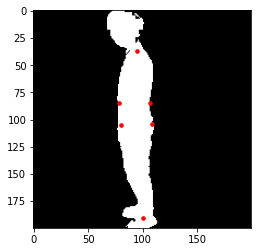

In [0]:
model.load_state_dict(torch.load(ROOT_FOLDER+'model.pt'))
predictions = predict(test_loader, model)

print('Error: ', np.linalg.norm(predictions-KPT_S_TEST.reshape((predictions.shape[0],-1)), axis=1).mean())

idx = 100
draw_points(IMG_S_TEST[idx,:,:], predictions[idx,:].reshape((-1,2)))

# Try another network CNN
I set number of filters as 65,130,260,520,1040,2080 separatly in nn.conv2d() 

The more the number of filters, the more feature CNN model will learn

Suprisingly, I delete the drop out function to try to achieve overfitting to see the error but it shows error is decreased. So i think it's my best error.


In [0]:
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()
        # 200 x 200
        self.conv1 = nn.Conv2d(1, 65, 5)
        # (w-f)/s+1 = 196
        self.pool1 = nn.MaxPool2d(2, 2)
        # 98
        self.conv2 = nn.Conv2d(65,130,3)
        # (98-3)/1 + 1 = 96
        self.pool2 = nn.MaxPool2d(2, 2)
        # 48
        self.conv3 = nn.Conv2d(130,260,3,stride=1)
        # (48-3)/1 + 1 = 46
        self.pool3 = nn.MaxPool2d(2, 2)
        # 23
        self.conv4 = nn.Conv2d(260,520,3,stride=2)
        # (23-3)/2 + 1 = 11
        self.conv5 = nn.Conv2d(520,1040,1,stride=2)
        # (11-1)/2+1 = 6
        #Linear Layer
        self.fc1 = nn.Linear(1040*6*6, 2080)
        self.fc2 = nn.Linear(2080, output_size)
        '''
        self.drop1 = nn.Dropout(p = 0.1)
        self.drop2 = nn.Dropout(p = 0.2)
        self.drop3 = nn.Dropout(p = 0.25)
        self.drop4 = nn.Dropout(p = 0.25)
        self.drop5 = nn.Dropout(p = 0.3)
        self.drop6 = nn.Dropout(p = 0.4)
        '''
    def forward(self, x):  
        x = self.pool1(F.relu(self.conv1(x)))
       # x = self.drop1(x)
        x = self.pool2(F.relu(self.conv2(x)))
       # x = self.drop2(x)
        x = self.pool3(F.relu(self.conv3(x)))
       # x = self.drop3(x)
        x = F.relu(self.conv4(x))
       # x = self.drop4(x)
        x = F.relu(self.conv5(x))
       # x = self.drop5(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
       # x = self.drop6(x)
        x = self.fc2(x)
        return x

learning rate=0.0001

n_epoches=1000

In [0]:
# if you find this step is slow, use GPU mode: Runtime-> change runtime type -> GPU
model = CNN(output_size=12)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses, valid_losses = train(train_loader, valid_loader,
                                   model, criterion, optimizer,
                                   n_epochs=1000,
                                   saved_model=ROOT_FOLDER+'model.pt')

Epoch: 1 	Training Loss: 0.057117 	Validation Loss: 0.037107
Validation loss decreased (inf --> 0.037107).  Saving model ...
Epoch: 2 	Training Loss: 0.031845 	Validation Loss: 0.029878
Validation loss decreased (0.037107 --> 0.029878).  Saving model ...
Epoch: 3 	Training Loss: 0.030580 	Validation Loss: 0.027881
Validation loss decreased (0.029878 --> 0.027881).  Saving model ...
Epoch: 4 	Training Loss: 0.028327 	Validation Loss: 0.028140
Epoch: 5 	Training Loss: 0.027036 	Validation Loss: 0.024949
Validation loss decreased (0.027881 --> 0.024949).  Saving model ...
Epoch: 6 	Training Loss: 0.025149 	Validation Loss: 0.025738
Epoch: 7 	Training Loss: 0.025182 	Validation Loss: 0.023982
Validation loss decreased (0.024949 --> 0.023982).  Saving model ...
Epoch: 8 	Training Loss: 0.023982 	Validation Loss: 0.024457
Epoch: 9 	Training Loss: 0.023878 	Validation Loss: 0.023803
Validation loss decreased (0.023982 --> 0.023803).  Saving model ...
Epoch: 10 	Training Loss: 0.023537 	Valida

my error is 0.060

It's the lowest error that I made. 

In [0]:
# Evaluate this one
model.load_state_dict(torch.load(ROOT_FOLDER+'model.pt'))
predictions = predict(test_loader, model)
np.save(ROOT_FOLDER+'s123456789.npy', predictions)

# baseline: 0.069
print('Error: ', np.linalg.norm(predictions-KPT_S_TEST.reshape((predictions.shape[0],-1)), axis=1).mean())

Error:  0.06068283605538413


257


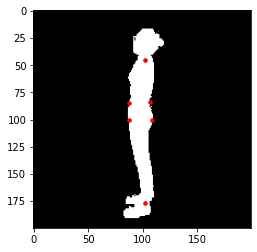

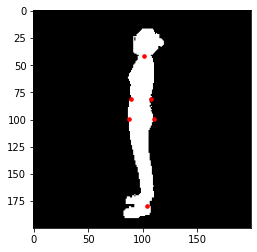

In [0]:
idx = np.random.randint(predictions.shape[0])
print(idx)
draw_points(IMG_S_TEST[idx,:,:], predictions[idx,:].reshape((-1,2)))
draw_points(IMG_S_TEST[idx,:,:], KPT_S_TEST[idx,:,:])

# Front View detection

Delete the KPT_S_TEST line because no test_kpt_side.npy files in the Google drive

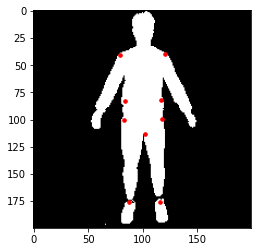

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def draw_points(image, kpts):
    plt.figure()
    plt.imshow(image, cmap='gray')
    keypoints = (kpts+0.5)*IMG_SIZE
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=50, marker='.', c='r')

# load side view data
IMG_SIZE = 200
IMG_S_TRAIN = np.load(ROOT_FOLDER+'data/train_img_front.npy')
IMG_S_TRAIN = np.unpackbits(IMG_S_TRAIN).reshape((-1,IMG_SIZE,IMG_SIZE))
IMG_S_TEST = np.load(ROOT_FOLDER+'data/test_img_front.npy')
IMG_S_TEST = np.unpackbits(IMG_S_TEST).reshape((-1,IMG_SIZE,IMG_SIZE))
KPT_S_TRAIN = np.load(ROOT_FOLDER+'data/train_kpt_front.npy')/IMG_SIZE - 0.5
#KPT_S_TEST = np.load(ROOT_FOLDER+'data/test_kpt_side.npy')/IMG_SIZE - 0.5

# show one
idx = 0
draw_points(IMG_S_TRAIN[idx,:,:], KPT_S_TRAIN[idx,:,:])

In [0]:
import torch
from torch.utils.data import Dataset

class SideKeypointsDataset(Dataset):
    '''Side View Keypoints Dataset'''
    def __init__(self, img, kpt, train=True, transform=None):
        self.img = img
        self.kpt = kpt
        self.train = train
        self.transform = transform
    
    def __len__(self):
        return self.img.shape[0]
    
    def __getitem__(self, idx):
        image = self.img[idx,:,:].astype(np.float32)
        if self.train:
            keypoints = self.kpt[idx,:,:].ravel().astype(np.float32)
        else:
            keypoints = None
        sample = {'image': image, 'keypoints': keypoints}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

def prepare_train_valid_loaders(trainset, valid_size=0.2, 
                                batch_size=128):
    '''
    Split trainset data and prepare DataLoader for training and validation
    
    Args:
        trainset (Dataset): data 
        valid_size (float): validation size, defalut=0.2
        batch_size (int) : batch size, default=128
    ''' 
    
    # obtain training indices that will be used for validation
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=valid_sampler)
    
    return train_loader, valid_loader

In [0]:
from torchvision import transforms
import cv2

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        new_w = np.random.randint(w, self.output_size)
        new_h = new_w
        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))    
        if key_pts is not None:
            return {'image': img, 'keypoints': key_pts}
        else:
            return {'image': img}

class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        if h == new_h:
            return sample
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        #left = top # temp
        image = image[top: top + new_h,
                      left: left + new_w]
        if key_pts is not None:
            #key_pts = key_pts - [left/output_size, top/output_size]
            key_pts[0::2] = ((key_pts[0::2]+0.5)*w-left)/new_w-0.5
            key_pts[1::2] = ((key_pts[1::2]+0.5)*h-top)/new_h-0.5
            return {'image': image, 'keypoints': key_pts}
        else:
            return {'image': image}

class ToTensor(object):
    '''Convert ndarrays in sample to Tensors.'''
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        image = torch.from_numpy(image)
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}

batch_size = 32
valid_size = 0.2 # percentage of training set to use as validation

# Define a transform to normalize the data
tsfm_train = transforms.Compose([Rescale(205), RandomCrop(200), ToTensor()])
tsfm_test = transforms.Compose([ToTensor()])

# Load the training data and test data
trainset = SideKeypointsDataset(IMG_S_TRAIN, KPT_S_TRAIN, transform=tsfm_train)
testset = SideKeypointsDataset(IMG_S_TEST, None, train=False, transform=tsfm_test)

# prepare data loaders
train_loader, valid_loader = prepare_train_valid_loaders(trainset, 
                                                         valid_size,
                                                         batch_size)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

# Neural Network Structure

In [0]:
from torch import nn, optim
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p =0.5):
        '''
        Buid a forward network with arbitrary hidden layers.
        Arguments
            ---------
            input_size (integer): size of the input layer
            output_size (integer): size of the output layer
            hidden_layers (list of integers):, the sizes of each hidden layers
        '''
        super(MLP, self).__init__()
        # hidden layers
        layer_sizes = [(input_size, hidden_layers[0])] \
                      + list(zip(hidden_layers[:-1], hidden_layers[1:]))
        self.hidden_layers = nn.ModuleList([nn.Linear(h1, h2) 
                                            for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        # flatten inputs
        x = x.view(x.shape[0], -1)
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = self.output(x)    
        return x

In [0]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50, saved_model='model.pt'):
    '''
    Train the model
    
    Args:
        train_loader (DataLoader): DataLoader for train Dataset
        valid_loader (DataLoader): DataLoader for valid Dataset
        model (nn.Module): model to be trained on
        criterion (torch.nn): loss funtion
        optimizer (torch.optim): optimization algorithms
        n_epochs (int): number of epochs to train the model
        saved_model (str): file path for saving model
    
    Return:
        tuple of train_losses, valid_losses
    '''

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*batch['image'].size(0)

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # update running validation loss 
            valid_loss += loss.item()*batch['image'].size(0)

        # print training/validation statistics 
        # calculate average Root Mean Square loss over an epoch
        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses

# set output_size=18 

# Front view key points=9x2=18

lr=0.0001

n_epoches=500

In [0]:
from torch import optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# output_size ?
# Front view keypoints: 9x2 = 18
model = MLP(input_size=IMG_SIZE*IMG_SIZE, output_size=18, 
            hidden_layers=[128, 64], drop_p=0.1)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses, valid_losses = train(train_loader, valid_loader,
                                   model, criterion, optimizer,
                                   n_epochs=500,
                                   saved_model=ROOT_FOLDER+'model.pt')

Epoch: 1 	Training Loss: 0.120717 	Validation Loss: 0.061749
Validation loss decreased (inf --> 0.061749).  Saving model ...
Epoch: 2 	Training Loss: 0.083406 	Validation Loss: 0.049598
Validation loss decreased (0.061749 --> 0.049598).  Saving model ...
Epoch: 3 	Training Loss: 0.075888 	Validation Loss: 0.038615
Validation loss decreased (0.049598 --> 0.038615).  Saving model ...
Epoch: 4 	Training Loss: 0.068336 	Validation Loss: 0.035752
Validation loss decreased (0.038615 --> 0.035752).  Saving model ...
Epoch: 5 	Training Loss: 0.064282 	Validation Loss: 0.031648
Validation loss decreased (0.035752 --> 0.031648).  Saving model ...
Epoch: 6 	Training Loss: 0.059929 	Validation Loss: 0.030633
Validation loss decreased (0.031648 --> 0.030633).  Saving model ...
Epoch: 7 	Training Loss: 0.056649 	Validation Loss: 0.037229
Epoch: 8 	Training Loss: 0.055779 	Validation Loss: 0.029072
Validation loss decreased (0.030633 --> 0.029072).  Saving model ...
Epoch: 9 	Training Loss: 0.052408 

# Evaluation

In [0]:
def predict(data_loader, model):
    '''
    Predict keypoints
    Args:
        data_loader (DataLoader): DataLoader for Dataset
        model (nn.Module): trained model for prediction.
    Return:
        predictions (array-like): keypoints in float (no. of images x keypoints).
    '''
    
    model.eval() # prep model for evaluation

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))

    return predictions

#Visualize the front view

I have to delete the print('Error:') line because no prediction error 

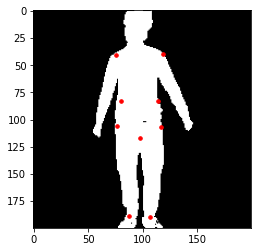

In [0]:
model.load_state_dict(torch.load(ROOT_FOLDER+'model.pt'))
predictions = predict(test_loader, model)

# print('Error: ', np.linalg.norm(predictions-KPT_S_TEST.reshape((predictions.shape[0],-1)), axis=1).mean())

idx = 100
draw_points(IMG_S_TEST[idx,:,:], predictions[idx,:].reshape((-1,2)))

# Try another network CNN

I set number of filters as 65,130,260,520,1040,2080 separately

In [0]:
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()
        # 200 x 200
        self.conv1 = nn.Conv2d(1, 65, 5)
        # (w-f)/s+1 = 196
        self.pool1 = nn.MaxPool2d(2, 2)
        # 98
        self.conv2 = nn.Conv2d(65,130,3)
        # (98-3)/1 + 1 = 96
        self.pool2 = nn.MaxPool2d(2, 2)
        # 48
        self.conv3 = nn.Conv2d(130,260,3,stride=1)
        # (48-3)/1 + 1 = 46
        self.pool3 = nn.MaxPool2d(2, 2)
        # 23
        self.conv4 = nn.Conv2d(260,520,3,stride=2)
        # (23-3)/2 + 1 = 11
        self.conv5 = nn.Conv2d(520,1040,1,stride=2)
        # (11-1)/2+1 = 6
        #Linear Layer
        self.fc1 = nn.Linear(1040*6*6, 2080)
        self.fc2 = nn.Linear(2080, output_size)
        
        self.drop1 = nn.Dropout(p = 0.1)
        self.drop2 = nn.Dropout(p = 0.2)
        self.drop3 = nn.Dropout(p = 0.25)
        self.drop4 = nn.Dropout(p = 0.25)
        self.drop5 = nn.Dropout(p = 0.3)
        self.drop6 = nn.Dropout(p = 0.4)

    def forward(self, x):  
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.drop3(x)
        x = F.relu(self.conv4(x))
        x = self.drop4(x)
        x = F.relu(self.conv5(x))
        x = self.drop5(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop6(x)
        x = self.fc2(x)
        return x

lr=0.0001

n_epoches=500

In [0]:
# if you find this step is slow, use GPU mode: Runtime-> change runtime type -> GPU
model = CNN(output_size=18)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses, valid_losses = train(train_loader, valid_loader,
                                   model, criterion, optimizer,
                                   n_epochs=500,
                                   saved_model=ROOT_FOLDER+'model.pt')

Epoch: 1 	Training Loss: 0.066250 	Validation Loss: 0.029822
Validation loss decreased (inf --> 0.029822).  Saving model ...
Epoch: 2 	Training Loss: 0.036841 	Validation Loss: 0.028822
Validation loss decreased (0.029822 --> 0.028822).  Saving model ...
Epoch: 3 	Training Loss: 0.034291 	Validation Loss: 0.028521
Validation loss decreased (0.028822 --> 0.028521).  Saving model ...
Epoch: 4 	Training Loss: 0.032153 	Validation Loss: 0.030999
Epoch: 5 	Training Loss: 0.030677 	Validation Loss: 0.032073
Epoch: 6 	Training Loss: 0.029381 	Validation Loss: 0.032618
Epoch: 7 	Training Loss: 0.028184 	Validation Loss: 0.026424
Validation loss decreased (0.028521 --> 0.026424).  Saving model ...
Epoch: 8 	Training Loss: 0.027170 	Validation Loss: 0.025081
Validation loss decreased (0.026424 --> 0.025081).  Saving model ...
Epoch: 9 	Training Loss: 0.026621 	Validation Loss: 0.025836
Epoch: 10 	Training Loss: 0.026070 	Validation Loss: 0.026378
Epoch: 11 	Training Loss: 0.025455 	Validation Lo

Delete the print("Error":)line as usual

In [0]:
# Evaluate this one
model.load_state_dict(torch.load(ROOT_FOLDER+'model.pt'))
predictions = predict(test_loader, model)
np.save(ROOT_FOLDER+'s1155132173.npy', predictions)

# baseline: 0.069
# print('Error: ', np.linalg.norm(predictions-KPT_S_TEST.reshape((predictions.shape[0],-1)), axis=1).mean())

Delete the draw_points() line 

The outcome seems pretty good

60


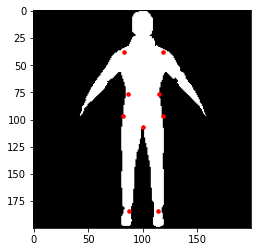

In [0]:
idx = np.random.randint(predictions.shape[0])
print(idx)
draw_points(IMG_S_TEST[idx,:,:], predictions[idx,:].reshape((-1,2)))
#draw_points(IMG_S_TEST[idx,:,:], KPT_S_TEST[idx,:,:])

In [41]:
# delete its output!
# Export the notebook as pdf
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!jupyter nbconvert --to PDF "./gdrive/My Drive/Colab Notebooks/Assignment2 3.23.ipynb"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
[NbConvertApp] Converting notebook ./gdrive/My Drive/Colab Notebooks/Assignment2 3.23.ipynb to PDF
[NbConvertApp] Support files will be in Assignment2 3.23_files/
[NbConvertApp] Making directory ./Assignment2 3.23_files
[NbConvertApp] Making directory ./Assignment2 3.23_files
[NbConvertApp] Making directory ./Assignment2 3.23_files
[NbConvertApp] Making directory ./Assignment2 3.23_files
[NbConvertApp] Making directory ./Assignment2 3.23_files
[NbConvertApp] Making directory ./Assignment2 3.23_files
[NbConvertApp] Making directory ./Assignment2 3.23_files
[NbConvertApp] Writing 3212